In [ ]:
#Importing key libraries, and reading data
import pandas as pd
import numpy as np

np.random.seed(2409)

import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Digit MNIST/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Digit MNIST/test.csv')

In [ ]:
df_train.head() # 784 features, 1 label

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Splitting into training and validation dataset
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

X_test = df_test.iloc[:, 0:784]

print(X_test.shape)

(28000, 784)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_features, df_label, 
                                                test_size = 0.2,
                                                random_state = 1212)

X_train = X_train.values.reshape(33600, 784) #(33600, 784)
X_cv = X_cv.values.reshape(8400, 784) #(8400, 784)

X_test = X_test.values.reshape(28000, 784)

In [ ]:
#Data cleaning, normalization and selection
print((min(X_train[1]), max(X_train[1])))

(0, 255)


In [ ]:
#As the pixel intensities are currently between the range of 0 and 255, we proceed to normalize the features, using broadcasting. In addition, we proceed to convert our labels from a class vector to binary One Hot Encoded
# Feature Normalization 
X_train = X_train.astype('float32'); X_cv= X_cv.astype('float32'); X_test = X_test.astype('float32')
X_train /= 255; X_cv /= 255; X_test /= 255

# Convert labels to One Hot Encoded
num_digits = 10
y_train = keras.utils.to_categorical(y_train, num_digits)
y_cv = keras.utils.to_categorical(y_cv, num_digits)

In [ ]:
# Printing 2 examples of labels after conversion
print(y_train[0]) # 2
print(y_train[3]) # 7

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
#Model Fitting
#We proceed by fitting several simple neural network models using Keras (with TensorFlow as our backend) and collect their accuracy. The model that performs the best on the validation set will be used as the model of choice for the competition.

#Model 1: Simple Neural Network with 2 layers (300, 200)

#In our first model, we will use the Keras library to train a neural network with the activation function set as ReLu. To determine which class to output, we will rely on the SoftMax function

In [ ]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 200
num_digits = 10

In [ ]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [ ]:
# Our model would have '4' layers - input layer, 2 hidden layer and 1 output layer
model = Model(Inp, output)
model.summary() # We have 297,910 parameters to estimate

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 300)               235500    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 200)               60200     
                                                                 
 Output_Layer (Dense)        (None, 10)                2010      
                                                                 
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Insert Hyperparameters
learning_rate = 0.1
training_epochs = 20
batch_size = 100

In [ ]:
# Customized Optimizer

from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops

class CustomAdam(Optimizer):
    
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, name='CustomAdam', **kwargs):
        super().__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or K.epsilon()

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
            self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var):
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1 = self._get_hyper('beta_1')
        beta_2 = self._get_hyper('beta_2')
        lr = self._get_hyper('learning_rate')
        t = self.iterations + 1
        lr_t = lr * math_ops.sqrt(1. - math_ops.pow(beta_2, t)) / (1. - math_ops.pow(beta_1, t))
        m_t = beta_1 * m + (1. - beta_1) * grad
        v_t = beta_2 * v + (1. - beta_2) * math_ops.square(grad)
        var_t = var - lr_t * m_t / (math_ops.sqrt(v_t) + self.epsilon)
        self._updates.append(K.update(m, m_t))
        self._updates.append(K.update(v, v_t))
        self._updates.append(K.update(var, var_t))

    def _resource_apply_sparse(self, grad, var, indices):
        raise NotImplementedError("Sparse gradient updates are not supported yet.")

    def get_config(self):
        config = super().get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon
        })
        return config


In [ ]:
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, **kwargs):
        super().__init__(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=CustomAdam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Epoch 1/20
336/336 - 5s - loss: 0.3130 - accuracy: 0.9103 - val_loss: 0.1514 - val_accuracy: 0.9565 - 5s/epoch - 15ms/step
Epoch 2/20
336/336 - 3s - loss: 0.1196 - accuracy: 0.9635 - val_loss: 0.1231 - val_accuracy: 0.9636 - 3s/epoch - 8ms/step
Epoch 3/20
336/336 - 2s - loss: 0.0772 - accuracy: 0.9762 - val_loss: 0.1022 - val_accuracy: 0.9683 - 2s/epoch - 7ms/step
Epoch 4/20
336/336 - 2s - loss: 0.0497 - accuracy: 0.9849 - val_loss: 0.0885 - val_accuracy: 0.9732 - 2s/epoch - 7ms/step
Epoch 5/20
336/336 - 2s - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.0941 - val_accuracy: 0.9731 - 2s/epoch - 7ms/step
Epoch 6/20
336/336 - 4s - loss: 0.0283 - accuracy: 0.9908 - val_loss: 0.1070 - val_accuracy: 0.9695 - 4s/epoch - 11ms/step
Epoch 7/20
336/336 - 3s - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.1110 - val_accuracy: 0.9714 - 3s/epoch - 8ms/step
Epoch 8/20
336/336 - 2s - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.1058 - val_accuracy: 0.9717 - 2s/epoch - 7ms/step
Epoch 9/20
336/336 - 3

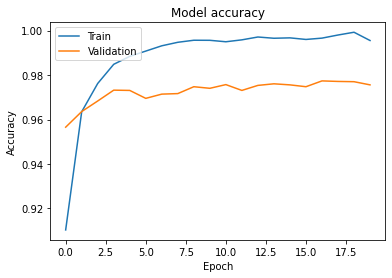

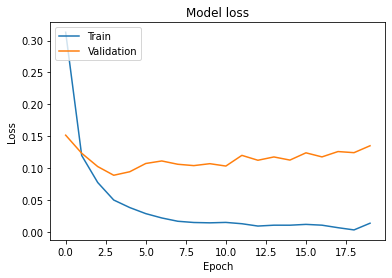

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history1 = model.fit(X_train, y_train,
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_data=(X_cv, y_cv))
plot_history(history1)

In [ ]:
#Execution Time 84.04 seconds